## Get identifiers for 16s

In [2]:
# This line imports the Bio.Entrez module, and makes it available
# as 'Entrez'.
from Bio import Entrez

# The line below imports the Bio.SeqIO module, which allows reading
# and writing of common bioinformatics sequence formats.
from Bio import SeqIO

# Create a new directory (if needed) for output/downloads
import os
outdir = "./ncbi_downloads"
os.makedirs(outdir, exist_ok=True)

# This line sets the variable 'Entrez.email' to the specified
# email address. You should substitute your own address for the
# example address provided below. Please do not provide a
# fake name.
Entrez.email = "evankomp@uw.edu"

# This line sets the name of the tool that is making the queries
Entrez.tool = "learn2therm"

In [53]:
handle = Entrez.esearch(db="nucleotide", term="33175[BioProject] OR 33317[BioProject]", retmax=26980)

# This line converts the returned information from NCBI into a form we
# can use, as before.
idlist = Entrez.read(handle)

In [54]:
idlist

{'Count': '26980', 'RetMax': '26980', 'RetStart': '0', 'IdList': ['2463901927', '2463901926', '2463901913', '2463901912', '2463901899', '2463901898', '2463901897', '2463901883', '2463901882', '2463901881', '2463901868', '2463901867', '2463901854', '2463901853', '2463901840', '2463901839', '2463901826', '2463901825', '2463901824', '2463901800', '2463901799', '2463901787', '2463901786', '2463901773', '2463901772', '2463901759', '2463901746', '2463901745', '2463901731', '2463901730', '2463901717', '2463901704', '2463901703', '2463901691', '2463901690', '2463901678', '2463901665', '2463901664', '2463901663', '2463901650', '2463901649', '2463901636', '2463901635', '2463901634', '2463901633', '2463901620', '2463901619', '2463901606', '2293356800', '2363087459', '2363087457', '2363087455', '2363087453', '2363087451', '2363087449', '2363087447', '2363087445', '2363087443', '2363087441', '2363087439', '2363087437', '2363087435', '2363087433', '2363087431', '2363087429', '2363087427', '236308742

In [55]:
len(idlist['IdList'])

26980

## retrieve sequences

In [56]:
handle = Entrez.efetch(db="nucleotide", rettype="gb", retmode="text",
    id=idlist['IdList'])


In [57]:
records = SeqIO.parse(handle, 'genbank')

In [58]:
total = 0
for record in records:
    total += 1
print(total)

9999


In [30]:
dir(record)

['__add__',
 '__bool__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__le___',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_per_letter_annotations',
 '_seq',
 '_set_per_letter_annotations',
 '_set_seq',
 'annotations',
 'dbxrefs',
 'description',
 'features',
 'format',
 'id',
 'letter_annotations',
 'lower',
 'name',
 'reverse_complement',
 'seq',
 'translate',
 'upper']

In [26]:
record.annotations

{'molecule_type': 'rRNA',
 'topology': 'linear',
 'data_file_division': 'BCT',
 'date': '29-NOV-2022',
 'accessions': ['NR_181936'],
 'sequence_version': 1,
 'keywords': ['RefSeq'],
 'source': 'Erysipelothrix anatis',
 'organism': 'Erysipelothrix anatis',
 'taxonomy': ['Bacteria',
  'Bacillota',
  'Erysipelotrichia',
  'Erysipelotrichales',
  'Erysipelotrichaceae',
  'Erysipelothrix'],
 'references': [Reference(title='New Erysipelothrix spp.', ...),
  Reference(title='Direct Submission', ...),
  Reference(title='Direct Submission', ...)],
 'comment': 'REVIEWED REFSEQ: This record has been curated by NCBI staff. The\nreference sequence is identical to ON024315.1:1-1371.',
 'structured_comment': OrderedDict([('Assembly-Data',
               OrderedDict([('Sequencing Technology',
                             'Sanger dideoxy sequencing')]))])}

In [33]:
dir(record.features[0])

['__bool__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_flip',
 '_get_location_operator',
 '_get_ref',
 '_get_ref_db',
 '_get_strand',
 '_set_location_operator',
 '_set_ref',
 '_set_ref_db',
 '_set_strand',
 '_shift',
 'extract',
 'id',
 'location',
 'location_operator',
 'qualifiers',
 'ref',
 'ref_db',
 'strand',
 'translate',
 'type']

In [45]:
record.features[0].type

'source'

In [37]:
record.features[0].qualifiers

OrderedDict([('organism', ['Erysipelothrix anatis']),
             ('mol_type', ['rRNA']),
             ('strain', ['D17_0559-3-2-1']),
             ('isolation_source', ['tissue samples Sinus nasalis of a duck']),
             ('type_material', ['type strain of Erysipelothrix anatis']),
             ('db_xref', ['taxon:2683713']),
             ('country', ['Germany'])])

In [43]:
record.seq

'AAGCTTGCTTCTTACAATCTTAGTGGCGAACGGGTGAGTAATACATAAGCAACCTGCCTCAATGCCTGGGATAACTGATGGAAACGTCAGCTAATACCGGATAGGTTAAGTCAAGACATCTTGATTTAATTAAAGATGGGATACATCACAATGAGATGGGCTTATGGCGCATTAGTTAGTTGGTGAGGTAACGGCTCACCAAGACGATGATGCGTAGCCAACCTGAGAGGGTGACCGGCCACACTGGGACTGAGACACGGCCCAGACTCCTACGGGAGGCAGCAGTAGGGAATTTTCGGCAATGGGGGAAACCCTGACCGAGCAACGCCGCGTGAGTGAAGAAGGCCTTCGGGTTGTAAAGCTCTGTTGTAAGGGAAGAACGATAGTTAGAGGGAATGCTAGCTATATGACGGTACCTTACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGAGCGCAGGCGGTTTATTAAGTTTATGGTGAAAGTTCGGGGCTCAACCCCGTGATGCCATAGAAACTGGTAGACTTGAGTACAGGAGAGGTTAGTGGAATTCCATGTGTAGCGGTAAAATGCGTAGATATATGGAGGAACACCAGTGGCGAAGGCGGCTAACTGGCCTGTAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAATAGGATTAGATACCCTAGTAGTCCACGCCGTAAACGATGGATACTAAGTGTTGGAGAAATTCAGTGCTGTAGTTAACGCAATAAGTATCCCGCCTGGGGAGTATGCGCGCAAGCGTAAAACTCAAAGGAATTGACGGGGGCCCGCACAAGCGGTGGAGTATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATACCGCGCAAAAGCATAGAGATATGTAATAGTTATGGCGGATACAGGTGGTGCATGGTTGTCGTCAGCTCGTGTCGTGAGATG

In [40]:
dir(record.seq)
    

['__abstractmethods__',
 '__add__',
 '__bytes__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_data',
 'back_transcribe',
 'complement',
 'complement_rna',
 'count',
 'count_overlap',
 'encode',
 'endswith',
 'find',
 'index',
 'join',
 'lower',
 'lstrip',
 'replace',
 'reverse_complement',
 'reverse_complement_rna',
 'rfind',
 'rindex',
 'rsplit',
 'rstrip',
 'split',
 'startswith',
 'strip',
 'tomutable',
 'transcribe',
 'translate',
 'ungap',
 'upper']

## load data sources and have a look

In [60]:
import pandas as pd

In [63]:
seq_16s = pd.read_csv('../tmp/16s.csv', index_col=0)

In [66]:
seq_16s['taxid'].value_counts()

1406       18
1121328    16
2320868    15
1285191    13
573        12
           ..
106370      1
222534      1
1616784     1
1652495     1
1870988     1
Name: taxid, Length: 21001, dtype: int64

We have multiple 16s for some taxa

In [68]:
sequences = seq_16s[seq_16s['taxid'] == 1406]['16s_seq']

In [83]:
sequences.apply(len)

12953    1547
12954    1547
12955    1547
12956    1547
12957    1547
12958    1545
12959    1545
12960    1545
12961    1545
12962    1543
12963    1545
12964    1543
12965    1545
12966    1543
16000    1521
17861    1479
18358    1504
23797    1491
Name: 16s_seq, dtype: int64

In [86]:
from Bio.Blast.Applications import NcbiblastnCommandline
from io import StringIO
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

# Create two sequence files
seq_records = []
for ind, s in sequences.items():
    seq_records.append(SeqRecord(Seq(s),
                   id=str(ind)))
SeqIO.write(seq_records, "./tmp/seqs.fasta", "fasta")

# Run BLAST and parse the output as XML
output = NcbiblastnCommandline(query="./tmp/seqs.fasta", subject="./tmp/seqs.fasta", outfmt=5)()[0]
blast_result_records = NCBIXML.parse(StringIO(output))

# Print some information on the result
ids = []
for record in blast_result_records:
    for alignment in record.alignments:
        for hsp in alignment.hsps:
            print('****Alignment****')
            print('sequence:', alignment.title)
            print('length:', alignment.length)
            id_ = 2*hsp.identities/(record.query_length + alignment.length)
            print('id', id_)
            ids.append(id_)

****Alignment****
sequence: 12953 12953 <unknown description>
length: 1547
id 1.0
****Alignment****
sequence: 12965 12965 <unknown description>
length: 1545
id 0.9961190168175937
****Alignment****
sequence: 12957 12957 <unknown description>
length: 1547
id 0.9961215255332903
****Alignment****
sequence: 12966 12966 <unknown description>
length: 1543
id 0.9948220064724919
****Alignment****
sequence: 12964 12964 <unknown description>
length: 1543
id 0.9948220064724919
****Alignment****
sequence: 12956 12956 <unknown description>
length: 1547
id 0.9935358758888171
****Alignment****
sequence: 12961 12961 <unknown description>
length: 1545
id 0.9922380336351876
****Alignment****
sequence: 12954 12954 <unknown description>
length: 1547
id 0.9922430510665805
****Alignment****
sequence: 12955 12955 <unknown description>
length: 1547
id 0.9915966386554622
****Alignment****
sequence: 12962 12962 <unknown description>
length: 1543
id 0.9909385113268608
****Alignment****
sequence: 16000 16000 <unkn

In [88]:
min(ids)

0.9676140118968936

The duplicates don't mutch matter. drop them.

In [90]:
seq_16s['len'] = seq_16s['16s_seq'].apply(len)

In [91]:
seq_16s['len'].describe()

count    26980.000000
mean      1449.481319
std         86.092216
min        302.000000
25%       1424.000000
50%       1463.000000
75%       1492.000000
max       3600.000000
Name: len, dtype: float64

In [92]:
seq_16s = seq_16s.sort_values('len', ascending=False)

In [96]:
seq_16s = seq_16s.drop_duplicates(subset='taxid', keep='first')

In [97]:
len(seq_16s)

21001

In [102]:
ogts = pd.read_csv('../tmp/ogt', index_col=0)

<AxesSubplot: ylabel='Frequency'>

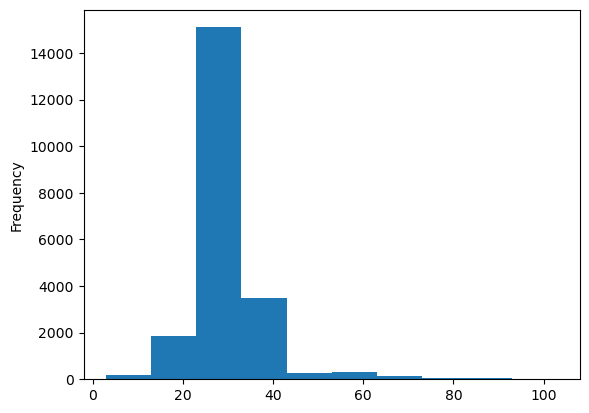

In [105]:
ogts['temperature'].plot.hist()

/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_17449/2403660626.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ogts.groupby('taxid').std()['temperature'].plot.hist()


<AxesSubplot: ylabel='Frequency'>

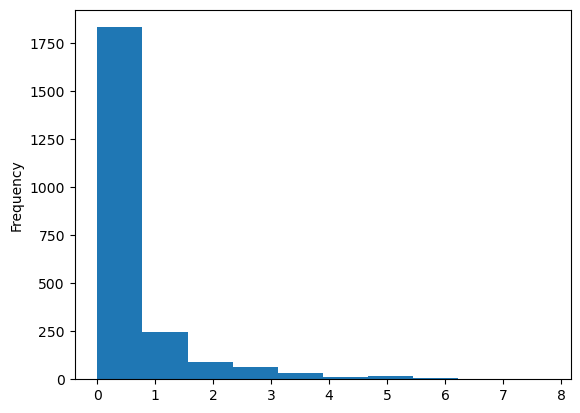

In [115]:
ogts.groupby('taxid').std()['temperature'].plot.hist()

In [118]:
groups = ogts.groupby('taxid')

for _, df_ in groups:
    if len(df_) > 1:
        print(df_['temperature'].min(), df_['temperature'].max(), df_['temperature'].max() - df_['temperature'].min())

23 27 4
27 27 0
16 16 0
26 28 2
28 30 2
28 28 0
26 28 2
27 27 0
15 15 0
27 28 1
22 25 3
30 30 0
30 30 0
30 30 0
30 30 0
30 30 0
30 30 0
37 37 0
30 30 0
26 29 3
26 30 4
30 31 1
37 37 0
37 37 0
37 37 0
37 37 0
37 37 0
37 37 0
37 37 0
21 21 0
18 26 8
32 36 4
30 30 0
31 31 0
30 31 1
30 30 0
31 33 2
25 26 1
25 25 0
30 32 2
30 30 0
31 31 0
29 30 1
32 33 1
29 30 1
70 71 1
56 57 1
29 29 0
26 37 11
21 23 2
28 29 1
28 37 9
26 30 4
26 28 2
30 30 0
29 29 0
30 30 0
30 31 1
29 29 0
26 27 1
29 30 1
26 28 2
26 27 1
26 26 0
28 28 0
26 27 1
27 27 0
26 26 0
27 30 3
29 29 0
26 29 3
30 30 0
26 27 1
26 27 1
37 37 0
37 37 0
37 37 0
37 37 0
33 34 1
30 37 7
35 37 2
34 35 1
35 37 2
37 37 0
33 37 4
37 37 0
37 37 0
20 20 0
29 30 1
30 31 1
26 30 4
29 30 1
33 35 2
35 37 2
29 36 7
27 29 2
30 34 4
26 30 4
27 28 1
26 29 3
36 37 1
33 33 0
34 37 3
30 32 2
33 34 1
30 30 0
30 32 2
35 37 2
35 37 2
34 37 3
35 37 2
26 27 1
30 31 1
35 37 2
30 37 7
29 37 8
32 33 1
18 21 3
26 37 11
23 26 3
26 33 7
29 31 2
26 26 0
29 32 3
30 33 

take the mean

In [122]:
ogts = ogts.groupby('taxid').mean().reset_index()

/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_17449/1196975326.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ogts = ogts.groupby('taxid').mean().reset_index()


In [126]:
df = ogts.merge(seq_16s, on='taxid', how='inner')

In [135]:
df[df['taxid']==1609559]

,taxid,temperature,superkingdom,phylum,class,order,family,genus,16s_seq,len
9436,1609559,100.0,2157.0,28890.0,183968.0,2258.0,2259.0,2260.0,GTACTCCCTTAATTCCGGTTGATCCTGCCGGAGGCCACTGCTATGG...,1557


In [139]:
df[df['taxid']==1609559].iloc[0]['16s_seq']

'GTACTCCCTTAATTCCGGTTGATCCTGCCGGAGGCCACTGCTATGGGGGTCCGACTAAGCCATGCGAGTCAAGGGGGCGTCCCTTCTGGGACGCCACCGGCGGACGGCTCAGTAACACGTCGGTAACCTACCCTCGGGAGGGGGATAACCCCGGGAAACTGGGGCTAATCCCCCATAGGCCTGGGGTACTGGAAGGTCCCCAGGCCGAAAGGGGACCGTAAGGTCCCGCCCGAGGATGGGCCGGCGGCCGATTAGGTAGTTGGTGGGGTAACGGCCCACCAAGCCGAAGATCGGTACGGGCCGTGAGAGCGGGAGCCCGGAGATGGACACTGAGACACGGGTCCAGGCCCTACGGGGCGCAGCAGGCGCGAAACCTCCGCAATGCGGGAAACCGCGACGGGGGGACCCCCAGTGCCGTGCCTCTGGCACGGCTTTTCCGGAGTGTAAAAAGCTCCGGGAATAAGGGCTGGGCAAGGCCGGTGGCAGCCGCCGCGGTAATACCGGCGGCCCGAGTGGTGGCCACTATTATTGGGCCTAAAGCGGCCGTAGCCGGGCCCGTAAGTCCCTGGCGAAATCCCACGGCTCAACCGTGGGGCTCGCTGGGGATACTGCGGGCCTTGGGACCGGGAGAGGCCGGGGGTACCCCCGGGGTAGGGGTGAAATCCTATAATCCCGGGGGGACCGCCAGTGGCGAAGGCGCCCGGCTGGAACGGGTCCGACGGTGAGGGCCGAAGGCCAGGGGAGCGAACCGGATTAGATACCCGGGTAGTCCTGGCTGTAAAGGATGCGGGCTAGGTGTCGGGCGAGCTTCGAGCTCGCCCGGTGCCGTAGGGAAGCCGTTAAGCCCGCCGCCTGGGGAGTACGGCCGCAAGGCTGAAACTTAAAGGAATTGGCGGGGGAGCACTACAAGGGGTGGAGCGTGCGGTTTAATTGGATTCAACGCCGGGAACCTCACCGGGGGCGACGGCAGGATGAAGGCCAGGCTGAAGGTCTTGCCGG

In [137]:
len("""ATTCCGGTTGATCCTGCCGGAGGCCACTGCTATGGGGGTCCGACTAAGCCATGCGAGTCAAGGGGGCGTC
CCTTCTGGGACGCCACCGGCGGACGGCTCAGTAACACGTCGGTAACCTACCCTCGGGAGGGGGATAACCC
CGGGAAACTGGGGCTAATCCCCCATAGGCCTGGGGTACTGGAAGGTCCCCAGGCCGAAAGGGGACCGTAA
GGTCCCGCCCGAGGATGGGCCGGCGGCCGATTAGGTAGTTGGTGGGGTAACGGCCCACCAAGCCGAAGAT
CGGTACGGGCCGTGAGAGCGGGAGCCCGGAGATGGACACTGAGACACGGGTCCAGGCCCTACGGGGCGCA
GCAGGCGCGAAACCTCCGCAATGCGGGAAACCGCGACGGGGGGACCCCCAGTGCCGTGCCTCTGGCACGG
CTTTTCCGGAGTGTAAAAAGCTCCGGGAATAAGGGCTGGGCAAGGCCGGTGGCAGCCGCCGCGGTAATAC
CGGCGGCCCGAGTGGTGGCCACTATTATTGGGCCTAAAGCGGCCGTAGCCGGGCCCGTAAGTCCCTGGCG
AAATCCCACGGCTCAACCGTGGGGCTCGCTGGGGATACTGCGGGCCTTGGGACCGGGAGAGGCCGGGGGT
ACCCCCGGGGTAGGGGTGAAATCCTATAATCCCGGGGGGACCGCCAGTGGCGAAGGCGCCCGGCTGGAAC
GGGTCCGACGGTGAGGGCCGAAGGCCAGGGGAGCGAACCGGATTAGATACCCGGGTAGTCCTGGCTGTAA
AGGATGCGGGCTAGGTGTCGGGCGAGCTTCGAGCTCGCCCGGTGCCGTAGGGAAGCCGTTAAGCCCGCCG
CCTGGGGAGTACGGCCGCAAGGCTGAAACTTAAAGGAATTGGCGGGGGAGCACTACAAGGGGTGGAGCGT
GCGGTTTAATTGGATTCAACGCCGGGAACCTCACCGGGGGCGACGGCAGGATGAAGGCCAGGCTGAAGGT
CTTGCCGGACGCGCCGAGAGGAGGTGCATGGCCGCCGTCAGCTCGTACCGTGAGGCGTCCACTTAAGTGT
GGTAACGAGCGAGACCCGCGCCCCCAGTTGCCAGTCCCTCCCGCTTGGGAGGGAGGCACTCTGGGGGGAC
TGCCGGCGATAAGCCGGAGGAAGGGGCGGGCGACGGTAGGTCAGTATGCCCCGAAACCCCCGGGCTACAC
GCGCGCTACAATGGGCGGGACAATGGGACCCGACCCCGAAAGGGGAAGGGAATCCCCTAAACCCGCCCTC
AGTTCGGATCGCGGGCTGCAACTCGCCCGCGTGAAGCTGGAATCCCTAGTACCCGCGCGTCATCATCGCG
CGGCGAATACGTCCCTGCTCCTTGCACACACCGCCCGTCACTCCACCCGAGCGGGGCCCGGGTGAGGCTC
GATCTCCTTCGGGAGGTCGGGTCGAGCCCGGGCTCCGTGAGGGGGGAGAAGTCGTAACAAGGTAGCCGTA
GGGGAACCTACGGCTCGATCACCTCCT""")

1518

blast online is happy with the 16s we have and the one I found when looking up the taxa

## Read uniprot data

In [9]:
import learn2therm.io
from Bio import SeqIO

In [40]:
records = learn2therm.io.seq_io_gnuzipped('../data/proteins/uniprot_sprot_archaea.xml.gz', filetype='uniprot-xml')

In [41]:
sum=0
for record in records:
    dbs = record.dbxrefs
    found = False
    for item in dbs:
        if item.startswith('NCBI Taxonomy'):
            id_ = item.split(':')[1]
            if len(id_)>0:
                found = True
            break
    if not found:
        print(f"Did not find {record.id}")
    sum +=1

In [31]:
sum

19701

In [32]:
record

SeqRecord(seq=Seq('MSESEQRHAHQCVSCGINIAGMSAATFKCPDCGQEISRCSKCRKQSNLYECPDCGFMGP'), id='D4GWB3', name='Z2753_HALVD', description='Zinc finger protein HVO_2753', dbxrefs=['AlphaFoldDB:D4GWB3', 'DOI:10.1111/febs.15559', 'DOI:10.1371/journal.pgen.1004784', 'DOI:10.1371/journal.pone.0009605', 'EMBL:AOHU01000047', 'EMBL:CP001956', 'EnsemblBacteria:ADE04009', 'EnsemblBacteria:ELY32345', 'GO:GO:0008270', 'GO:GO:0090606', 'GO:GO:0097590', 'GeneID:8925692', 'HOGENOM:CLU_196471_0_0_2', 'InterPro:IPR011668', 'InterPro:IPR044720', 'KEGG:hvo:HVO_2753', 'NCBI Taxonomy:309800', 'OMA:KCGFEGP', 'OrthoDB:35104at2157', 'PANTHER:PTHR40733', 'PANTHER:PTHR40733:SF1', 'PATRIC:fig|309800.29.peg.1774', 'PDB:6YDH', 'PDBsum:6YDH', 'Pfam:PF07754', 'Proteomes:UP000008243', 'Proteomes:UP000011532', 'PubMed:20333302', 'PubMed:25393412', 'PubMed:32905660', 'RefSeq:WP_004042997.1', 'SMR:D4GWB3', 'STRING:309800.C498_09054', 'Swiss-Prot:A0A384LLU8', 'Swiss-Prot:D4GWB3', 'Swiss-Prot:L9V568', 'Swiss-Prot:Z2753_HALVD', 'eggN

In [13]:
dir(record)

['__add__',
 '__bool__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__le___',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_per_letter_annotations',
 '_seq',
 '_set_per_letter_annotations',
 '_set_seq',
 'annotations',
 'dbxrefs',
 'description',
 'features',
 'format',
 'id',
 'letter_annotations',
 'lower',
 'name',
 'reverse_complement',
 'seq',
 'translate',
 'upper']

In [46]:
record.annotations

{'dataset': 'Swiss-Prot',
 'created': '2022-02-23',
 'modified': '2023-02-22',
 'version': 55,
 'accessions': ['D4GWB3', 'A0A384LLU8', 'L9V568'],
 'recommendedName_fullName': ['Zinc finger protein HVO_2753'],
 'alternativeName_fullName': ['Small CPxCG-related zinc finger protein',
  'Zinc finger u-protein HVO_2753',
  'Zn-ribbon RNA-binding protein'],
 'gene_name_ordered locus': ['HVO_2753'],
 'gene_name_ORF': ['C498_09054'],
 'taxonomy': ['Archaea',
  'Euryarchaeota',
  'Stenosarchaea group',
  'Halobacteria',
  'Haloferacales',
  'Haloferacaceae',
  'Haloferax'],
 'organism': 'Haloferax volcanii (strain ATCC 29605 / DSM 3757 / JCM 8879 / NBRC 14742 / NCIMB 2012 / VKM B-1768 / DS2) (Halobacterium volcanii)',
 'references': [Reference(title='The complete genome sequence of Haloferax volcanii DS2, a model archaeon.', ...),
  Reference(title='Phylogenetically driven sequencing of extremely halophilic archaea reveals strategies for static and dynamic osmo-response.', ...),
  Reference(tit

## Read parquet files from proteins

In [47]:
import pandas as pd

In [48]:
pd.read_parquet('../data/proteins/uniprot_chunk_0.parquet')

,pid,taxid,protein_seq
